<a href="https://colab.research.google.com/github/JTenaSan/22FCS2050/blob/main/Spotify_EDA_Modeling_Jesus_Tena.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
import kagglehub
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Download latest version
path = kagglehub.dataset_download("irynatokarchuk/top-streamed-spotify-songs-by-year-2010-2023")
print("Path to dataset files:", path)

# Check if the downloaded folder exists
if os.path.exists(path):
    # List the files in the downloaded folder
    files = os.listdir(path)
    print("Files in the downloaded folder:", files)

    # Find the CSV file
    csv_file = next((f for f in files if f.endswith('.csv')), None)

    if csv_file:
        file_path = os.path.join(path, csv_file)  # Use the found CSV file
        df = pd.read_csv(file_path)
    else:
        print("CSV file not found in the downloaded folder.")
else:
    print("Downloaded folder not found.")


encoder = OneHotEncoder()

100%|██████████| 425k/425k [00:00<00:00, 21.2MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/irynatokarchuk/top-streamed-spotify-songs-by-year-2010-2023/versions/1
Files in the downloaded folder: ['spotify_full_list_20102023.csv']


# Linear Regression Model

In [11]:
# Encode 'main_genre'
encoded_genres = encoder.fit_transform(df[['main_genre']]).toarray()
encoded_genres_df = pd.DataFrame(encoded_genres, columns=[f'genre_{i}' for i in range(encoded_genres.shape[1])]) # Create a DataFrame for encoded genres
df = pd.concat([df, encoded_genres_df], axis=1) # Concatenate the encoded genres with the original DataFrame

# Encode 'Artist'
encoded_artist = encoder.fit_transform(df[['Artist']]).toarray()
encoded_artist_df = pd.DataFrame(encoded_artist, columns=[f'genre_{i}' for i in range(encoded_artist.shape[1])]) # Create a DataFrame for encoded Artist
df = pd.concat([df, encoded_artist_df], axis=1) # Concatenate the encoded Artist with the original DataFrame

# Scales 'Streams'
scaler = StandardScaler()
df['Streams'] = scaler.fit_transform(df[['Streams']])

# Splits into train and test
genre_columns = encoded_genres_df.columns # Get the genre column names
X = df[list(genre_columns) + ['Daily']]  # Select genre columns and 'Streams' for features
y = df['Streams']  # Example target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

In [ ]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R²: {r2}")

RMSE: 0.6712026062104697
R²: 0.5417919169529322


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Based on the r2 it seems that the main genre has a .54, meaning it does not really have a strong relationship between genre and daily (x variables) and Streams (y).

In [ ]:
artist_columns = encoded_artist_df.columns
X = df[list(genre_columns) + list(artist_columns)]  # Select genre columns and 'Streams' for features
y = df['Streams']  # Example target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model2 = LinearRegression()
model2.fit(X_train, y_train)

# Predictions
y_pred2 = model2.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R²: {r2}")

RMSE: 0.6712026062102694
R²: 0.5417919169532057


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Now as for the correlation between Artist and the main_genre that would predict the Streams we can see that the r2 is only at .54 as well for predicting total number of Streams, meaning just like with the genres we have a pretty decent correlation betwen genre + artists.

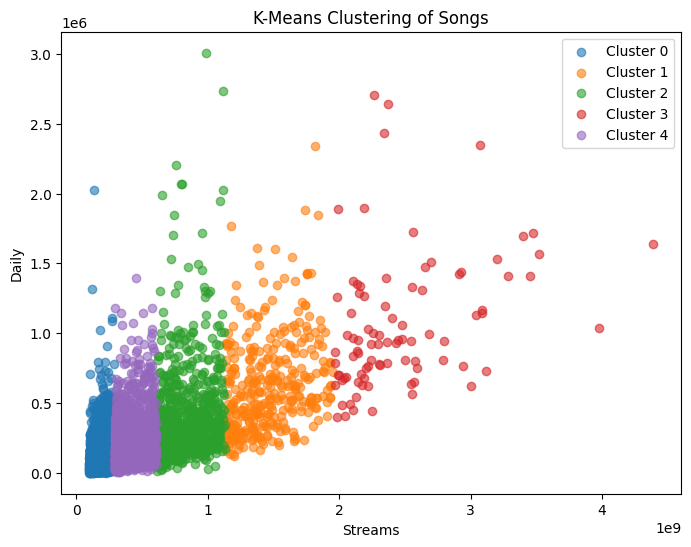

In [4]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster'] = kmeans.fit_predict(df[['Streams', 'Daily']])

plt.figure(figsize=(8, 6))
for cluster in range(5):  # 5 clusters as an example
    cluster_data = df[df['Cluster'] == cluster]
    plt.scatter(cluster_data['Streams'], cluster_data['Daily'], label=f'Cluster {cluster}', alpha=0.6)

plt.title('K-Means Clustering of Songs')
plt.xlabel('Streams')
plt.ylabel('Daily')
plt.legend()
plt.show()

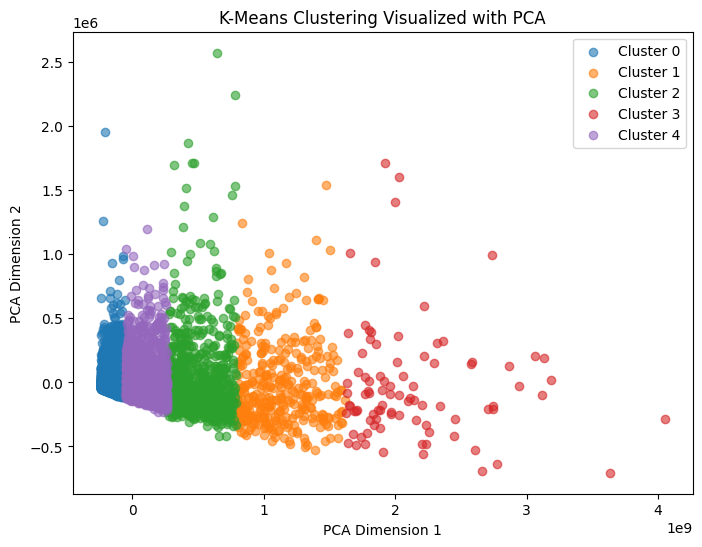

In [7]:
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(df[['Streams', 'Daily', 'year']])
df['PCA1'] = data_pca[:, 0]
df['PCA2'] = data_pca[:, 1]
# Plot clusters in PCA-reduced space
plt.figure(figsize=(8, 6))
for cluster in range(5):
    cluster_data = df[df['Cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}', alpha=0.6)

plt.title('K-Means Clustering Visualized with PCA')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.legend()
plt.show()

In [8]:
from sklearn.ensemble import IsolationForest

# Select features for anomaly detection
X = df[['Streams', 'Daily']].values

# Apply Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # 5% of data considered outliers
outlier_labels = iso_forest.fit_predict(X)

# Add outlier labels to the dataset (-1 = outlier, 1 = inlier)
df['Outlier'] = outlier_labels

# Filter outliers
outliers = df[df['Outlier'] == -1]
print(f"Number of outliers detected: {len(outliers)}")

Number of outliers detected: 522


In [10]:
# Calculate Z-scores for numeric features
df['Streams_Z'] = (df['Streams'] - df['Streams'].mean()) / df['Streams'].std()

# Identify outliers (e.g., Z-score > 3 or < -3)
outliers = df[np.abs(df['Streams_Z']) > 3]
print(f"Number of outliers: {len(outliers)}")

Number of outliers: 268
